In [1]:
# Importing the necessary packages
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Loading the data
nba_dataset = pd.read_csv("nba.csv")


In [3]:
# Data inspection and 

# print(nba_dataset.columns)
print(nba_dataset.info())
# print(nba_dataset.describe())
# X_nba[nba_dataset["3P%"].isnull()]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
Name    1340 non-null object
GP      1340 non-null int64
MIN     1340 non-null float64
PPT     1340 non-null float64
FGM     1340 non-null float64
FGA     1340 non-null float64
FG%     1340 non-null float64
3PM     1340 non-null float64
3PA     1340 non-null float64
3P%     1329 non-null float64
FTM     1340 non-null float64
FTA     1340 non-null float64
FT%     1340 non-null float64
OREB    1340 non-null float64
DREB    1340 non-null float64
REB     1340 non-null float64
AST     1340 non-null float64
STL     1340 non-null float64
BLK     1340 non-null float64
TOV     1340 non-null float64
TAR     1340 non-null int64
dtypes: float64(18), int64(2), object(1)
memory usage: 219.9+ KB
None


In [4]:
# Addressing the null value by Winsorizing

'''
t1 = np.nanmean(nba_dataset["3P%"])
t1 = round(t1, 3)

def f1(x):
    if x != x:
        return t1
    else:
        return x

nba_dataset["3P%"] = nba_dataset["3P%"].apply(f1)
nba_dataset[nba_dataset["3P%"].isnull()]

'''

# Or Addressing the null value by removing them
nba_dataset = nba_dataset[nba_dataset["3P%"].notnull()]


In [5]:
# Separating the features and label
X_nba = nba_dataset.iloc[:,1:-1] # Dropping the first column that contains name field (Not useful for ML), Last column is label
y_nba = nba_dataset.iloc[:,-1]


AxesSubplot(0.125,0.125;0.775x0.755)


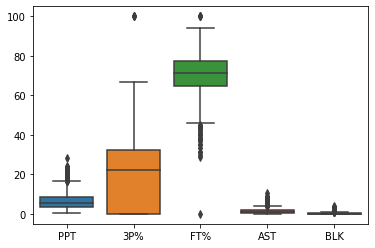

In [6]:
# Data visualization for outliers

# print(sns.boxplot(data = X_nba.iloc[:,0:4], width = 0.8))
# print(sns.boxplot(data = X_nba.iloc[:,4:8]))
# print(sns.boxplot(data = X_nba.iloc[:,8:12]))
# print(sns.boxplot(data = X_nba.iloc[:,12:16]))
# print(sns.boxplot(data = X_nba.iloc[:,16:19]))

# Possible presence of outliers in fields PPT, 3P%, FT%, AST, BLK
print(sns.boxplot(data = X_nba[['PPT','3P%','FT%','AST','BLK']]))


In [7]:
# Printing the max min values of the fields having outliers
print('PPT max: ', X_nba[['PPT']].max())
print('PPT min: ', X_nba[['PPT']].min())

print('3P% max: ', X_nba[['3P%']].max())
print('3P% min: ', X_nba[['3P%']].min())

print('FT% max: ', X_nba[['FT%']].max())
print('FT% min: ', X_nba[['FT%']].min())

print('AST max: ', X_nba[['AST']].max())
print('AST min: ', X_nba[['AST']].min())

print('BLK max: ', X_nba[['BLK']].max())
print('BLK min: ', X_nba[['BLK']].min())


PPT max:  PPT    28.2
dtype: float64
PPT min:  PPT    0.7
dtype: float64
3P% max:  3P%    100.0
dtype: float64
3P% min:  3P%    0.0
dtype: float64
FT% max:  FT%    100.0
dtype: float64
FT% min:  FT%    0.0
dtype: float64
AST max:  AST    10.6
dtype: float64
AST min:  AST    0.0
dtype: float64
BLK max:  BLK    3.9
dtype: float64
BLK min:  BLK    0.0
dtype: float64


In [8]:
# Outlier processing

for i in range(len(X_nba.columns)):        
    lv, uv = (0, 0)
    if X_nba.iloc[:,i].min() < 0:
        lv, uv = np.percentile(X_nba.iloc[:,i], [1,98])
    else:
        lv, uv = np.percentile(X_nba.iloc[:,i], [0,98])
    
    X_nba.iloc[:,i] = np.clip(X_nba.iloc[:,i], lv, uv)


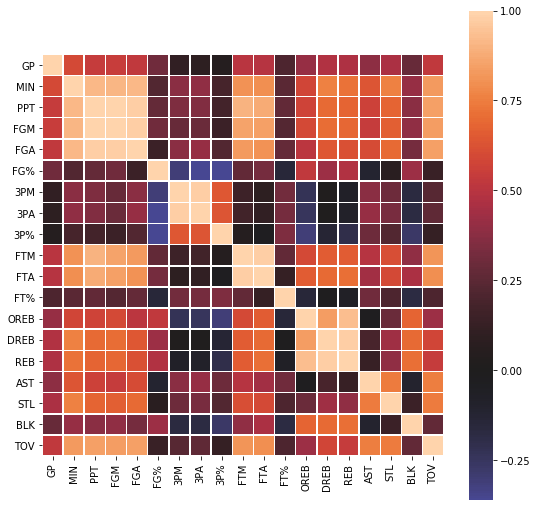

In [9]:
# Plotting the correlation matrix
X_correlation = X_nba.corr()

f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(X_correlation, center = 0, square = True, linewidths = 0.5)


In [10]:
# Calculating Variation Inflation Factor (VIF) to obtain colinearity among features

X_nba_scaled = StandardScaler().fit_transform(X_nba)
vif = pd.Series([variance_inflation_factor(X_nba_scaled, i) for i in range(X_nba_scaled.shape[1])], X_nba.columns)

print(vif)


GP        1.724674
MIN      17.327732
PPT     972.624008
FGM     606.680528
FGA     127.747684
FG%       4.217940
3PM      45.050580
3PA      41.539527
3P%       1.996388
FTM     113.297836
FTA      73.874232
FT%       2.689233
OREB     93.252178
DREB    280.824880
REB     626.930150
AST       5.384609
STL       3.532096
BLK       2.324645
TOV       7.987843
dtype: float64


In [11]:
# The VIF value larger than 5 depicts the presence of collinearity among features.
# Applying PCA to reduce collinearity

nba_pca_model = PCA(n_components = 0.95, svd_solver = 'full')
X_nba_pca = nba_pca_model.fit_transform(X_nba_scaled)

print(nba_pca_model.explained_variance_)
print(nba_pca_model.explained_variance_ratio_)


[9.60533294 4.00226214 1.24588756 0.86493313 0.71259076 0.57382652
 0.44116053 0.43563705 0.35665594]
[0.50516344 0.21048688 0.06552369 0.04548854 0.03747656 0.03017867
 0.0232015  0.02291101 0.01875724]


AxesSubplot(0.125,0.1925;0.62x0.62)
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
dtype: float64


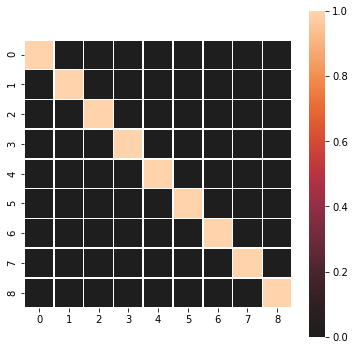

In [12]:
X_nba_pca_df = pd.DataFrame(X_nba_pca)

# print(X_nba_pca_df.shape)
X_nba_pca_df.head()

# Plotting the correlation matrix after PCA to check whether correlation among features has reduced
X_corr_new = X_nba_pca_df.corr()

f, ax = plt.subplots(figsize=(6, 6))
print(sns.heatmap(X_corr_new, center=0, square=True, linewidths=.5))

# Fresh calculations of VIF to ensure the VIF is less than 5 after the application of PCA
vif_new = pd.Series([variance_inflation_factor(X_nba_pca_df.values, i) for i in range(X_nba_pca_df.shape[1])], X_nba_pca_df.columns)
print(vif_new)


In [13]:
# Splitting of train test dataset
# X_train, X_test, y_train, y_test = train_test_split(X_nba_pca, y_nba, test_size = 0.20, shuffle = True, random_state = 42)
# X_train, X_test, y_train, y_test = train_test_split(X_nba_scaled, y_nba, test_size = 0.20, shuffle = True)
# X_train, X_test, y_train, y_test = train_test_split(X_nba, y_nba, test_size = 0.20, shuffle = True)


In [14]:
# The code in this section is for predicting with the K-nearest neighbors classifier 
# GridSearchCV() is used for finding the best hyperparameters

X_train, X_test, y_train, y_test = train_test_split(X_nba_scaled, y_nba, test_size = 0.20, shuffle = True)

knn_classifier = KNeighborsClassifier(n_jobs = -1)
parameters = {'n_neighbors':[10,15,20,25,30]}
gs_knn = GridSearchCV(knn_classifier, param_grid = parameters, cv = 10)

gs_knn.fit(X_train, y_train)
y_pred_knn = gs_knn.predict(X_test)

best_score_knn = f1_score(y_test, y_pred_knn, average = 'weighted')
best_score_knn = round(best_score_knn, 2)

print('Best F1 score by KNN is:', best_score_knn)
print('Best hyper parameters are:', gs_knn.best_params_)


Best F1 score by KNN is: 0.68
Best hyper parameters are: {'n_neighbors': 30}


In [15]:
# The code in this section is for predicting with the Random forest classifier 
# GridSearchCV() is used for finding the best hyperparameters

X_train, X_test, y_train, y_test = train_test_split(X_nba_scaled, y_nba, test_size = 0.20, shuffle = True)

rf_classifier = RandomForestClassifier(n_jobs = -1)
parameters = {'n_estimators':[10,15,20,30,50,100], 'max_depth':(5,10,15,20,25)}
gs_rf = GridSearchCV(rf_classifier, param_grid = parameters, cv = 10)

gs_rf.fit(X_train, y_train)
y_pred_rf = gs_rf.predict(X_test)

best_score_rf = f1_score(y_test, y_pred_rf)
best_score_rf = round(best_score_rf, 2)

print('Best F1 score by Random Forest is:', best_score_rf)
print('Best hyper parameters are:', gs_rf.best_params_)


Best F1 score by Random Forest is: 0.75
Best hyper parameters are: {'max_depth': 20, 'n_estimators': 100}


In [16]:
# The code in this section is for predicting with the Logistic regression 
# GridSearchCV() is used for finding the best hyperparameters

# X_train, X_test, y_train, y_test = train_test_split(X_nba_pca, y_nba, test_size = 0.20, shuffle = True)
X_train, X_test, y_train, y_test = train_test_split(X_nba_scaled, y_nba, test_size = 0.20, shuffle = True)

lr_classifier = LogisticRegression()
parameters_0 = {'solver':['saga'], 'penalty':['l1'], 'C':[10,5,2,1,0.5,0.2,0.1]}
parameters_1 = {'solver':['saga'], 'penalty':['l2'], 'C':[10,5,2,1,0.5,0.2,0.1]}
parameters_3 = {'solver':['lbfgs'], 'penalty':['l2'], 'C':[10,5,2,1,0.5,0.2,0.1]}
parameters_4 = {'solver':['saga'], 'penalty':['elasticnet'], 'C':[10,5,2,1,0.5,0.2,0.1], 'l1_ratio':[0.25, 0.5, 0.75]}
parameters_5 = {'solver':['lbfgs'], 'penalty':['none'], 'C':[10,5,2,1,0.5,0.2,0.1]}

param = [parameters_0, parameters_1, parameters_3, parameters_4, parameters_5]
loop = 1

optimal_score_lr = 0
for p in param:
    gs_lr = GridSearchCV(lr_classifier, param_grid = p, cv = 10)
    gs_lr.fit(X_train, y_train)
    y_pred_lr = gs_lr.predict(X_test)
    best_score_lr = f1_score(y_test, y_pred_lr)
    best_score_lr = round(best_score_lr, 2)
    
    print()
    print('Best F1 score by Logistic Regression with param set ' + str(loop) + ' is:', best_score_lr)
    print('Best hyper parameters are:', gs_lr.best_params_)
    print()
    print('-'*75)
    loop += 1
    
    if best_score_lr > optimal_score_lr:
        optimal_score_lr = best_score_lr



Best F1 score by Logistic Regression with param set 1 is: 0.79
Best hyper parameters are: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}

---------------------------------------------------------------------------

Best F1 score by Logistic Regression with param set 2 is: 0.8
Best hyper parameters are: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}

---------------------------------------------------------------------------

Best F1 score by Logistic Regression with param set 3 is: 0.8
Best hyper parameters are: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

---------------------------------------------------------------------------

Best F1 score by Logistic Regression with param set 4 is: 0.79
Best hyper parameters are: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}

---------------------------------------------------------------------------

Best F1 score by Logistic Regression with param set 5 is: 0.79
Best hyper parameters are: {'C': 10, 'penalty': 'none', 'solve

In [17]:
# The code in this section is for predicting with the ANN
# GridSearchCV() is used for finding the best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_nba_scaled, y_nba, test_size = 0.20, shuffle = True)

mlp_classifier = MLPClassifier()
parameters = {'hidden_layer_sizes':[(3,), (5,), (8,)], 'alpha':[0.0001, 0.001], 'learning_rate_init':[0.001, 0.01]}

gs_ann = GridSearchCV(mlp_classifier, param_grid = parameters, cv = 10)

gs_ann.fit(X_train, y_train)
y_pred_ann = gs_ann.predict(X_test)

best_score_ann = f1_score(y_test, y_pred_ann)
best_score_ann = round(best_score_ann, 2)

print('Best F1 score by ANN is:', best_score_ann)
print('Best hyper parameters are:', gs_ann.best_params_)


Best F1 score by ANN is: 0.78
Best hyper parameters are: {'alpha': 0.001, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.001}


In [18]:
# Performance comparison of various models
print('Best F1 score by KNN is:', best_score_knn)
print('Best F1 score by Random Forest is:', best_score_rf)
print('Best F1 score by Logistic Regression is:', optimal_score_lr)
print('Best F1 score by ANN is:', best_score_ann)

best_scores = {'KNN': best_score_knn, 'Random Forest': best_score_rf, 'Logistic Regression': optimal_score_lr, \
               'ANN': best_score_ann}

sorted_best = sorted(best_scores.items(), key = lambda x: x[1])
print('The model with the best F1 score and the corresponding score is:', sorted_best[-1])


Best F1 score by KNN is: 0.68
Best F1 score by Random Forest is: 0.75
Best F1 score by Logistic Regression is: 0.8
Best F1 score by ANN is: 0.78
The model with the best F1 score and the corresponding score is: ('Logistic Regression', 0.8)
